# Closed shell reactions with core correlation

Bak et al., [doi:10.1063/1.1357225](https://doi.org/10.1063/1.1357225) and [doi:10.1063/1.481544](https://doi.org/10.1063/1.481544)

In [1]:
import pymolpro
import pandas as pd

In [2]:
backend = 'local'  # If preferred, change this to one of the backends in your ~/.sjef/molpro/backends.xml that is ssh-accessible
project_name = 'Core_Valence_reactions'
parallel = None  # how many jobs to run at once

In [3]:
methods = ['HF', 'MP2', 'CCSD', 'CCSD(T)']
bases = ['cc-pCVDZ', 'cc-pCVTZ', 'cc-pCVQZ', 'cc-pCV5Z']

In [4]:
closed_shell_methods = {'B3LYP': "ks, b3lyp", "HF": "hf", "MP2": "mp2", "MP3": "mp3", "MP4": "mp4", "CCSD": "ccsd",
                        "CCSD(T)": "ccsd(t)", "PAPT2": "papt;mp2", "PAPT3": "papt;mp3", "PAPT4": "papt;mp4"}

In [5]:
db = pymolpro.database.library("Bak2000_reactions")

In [6]:
results = {}
for method in methods:
    results[method] = {}
    for basis in bases:
        results[method][basis] = pymolpro.database.run(db, method, basis, location=project_name, backend=backend,
                                                       preamble="core,small")

## Extrapolation

In [7]:
extrapolations = {}
if 'cc-pCVDZ' in bases and 'cc-pCVTZ' in bases:
    extrapolations["cc-pCV[23]Z"] = {'x': 2, 'first': 'cc-pCVDZ', 'second': 'cc-pCVTZ'}
if 'cc-pCVTZ' in bases and 'cc-pCVQZ' in bases:
    extrapolations["cc-pCV[34]Z"] = {'x': 3, 'first': 'cc-pCVTZ', 'second': 'cc-pCVQZ'}
if 'cc-pCVQZ' in bases and 'cc-pCV5Z' in bases:
    extrapolations["cc-pCV[45]Z"] = {'x': 4, 'first': 'cc-pCVQZ', 'second': 'cc-pCV5Z'}

for extr in extrapolations:
    x = extrapolations[extr]['x']
    xbas = extrapolations[extr]['first']
    xpbas = extrapolations[extr]['second']
    for method in methods:
        results[method][extr] = pymolpro.database.basis_extrapolate(
            [results[method][xbas], results[method][xpbas]],
            [results['HF'][xbas], results['HF'][xpbas]],
            [x, x + 1]
        )
    bases.append(extr) if extr not in bases else ""


In [8]:
tokj = 2625.49963948
pd.set_option('display.precision', 2)
method_errors = pymolpro.database.compare([results[method]['cc-pCV5Z'] for method in methods], db.reference_results())[
                    'reaction statistics'] * tokj
method_errors

,HF,MP2,CCSD,CCSD(T)
,cc-pCV5Z,cc-pCV5Z,cc-pCV5Z,cc-pCV5Z
mean,9.25,-10.49,-5.78,0.39
stdev,41.24,18.17,9.20,1.51
meanabs,29.06,14.46,9.37,1.30
maxabs,113.66,50.01,17.72,3.00


In [9]:
pd.set_option('display.precision', 2)
basis_errors = pymolpro.database.compare([results['CCSD(T)'][basis] for basis in bases], db.reference_results())[
                   'reaction statistics'] * tokj
basis_errors

CCSD(T)                                                     \
        cc-pCVDZ cc-pCVTZ cc-pCVQZ cc-pCV5Z cc-pCV[23]Z cc-pCV[34]Z   
mean       33.39    11.31     3.02     0.39        2.70       -1.13   
stdev      25.92     8.07     2.88     1.51        4.83        1.23   
meanabs    36.73    12.05     3.70     1.30        4.37        1.33   
maxabs     65.92    21.33     6.97     3.00       10.79        3.15   

                     
        cc-pCV[45]Z  
mean          -0.83  
stdev          1.22  
meanabs        1.19  
maxabs         3.49

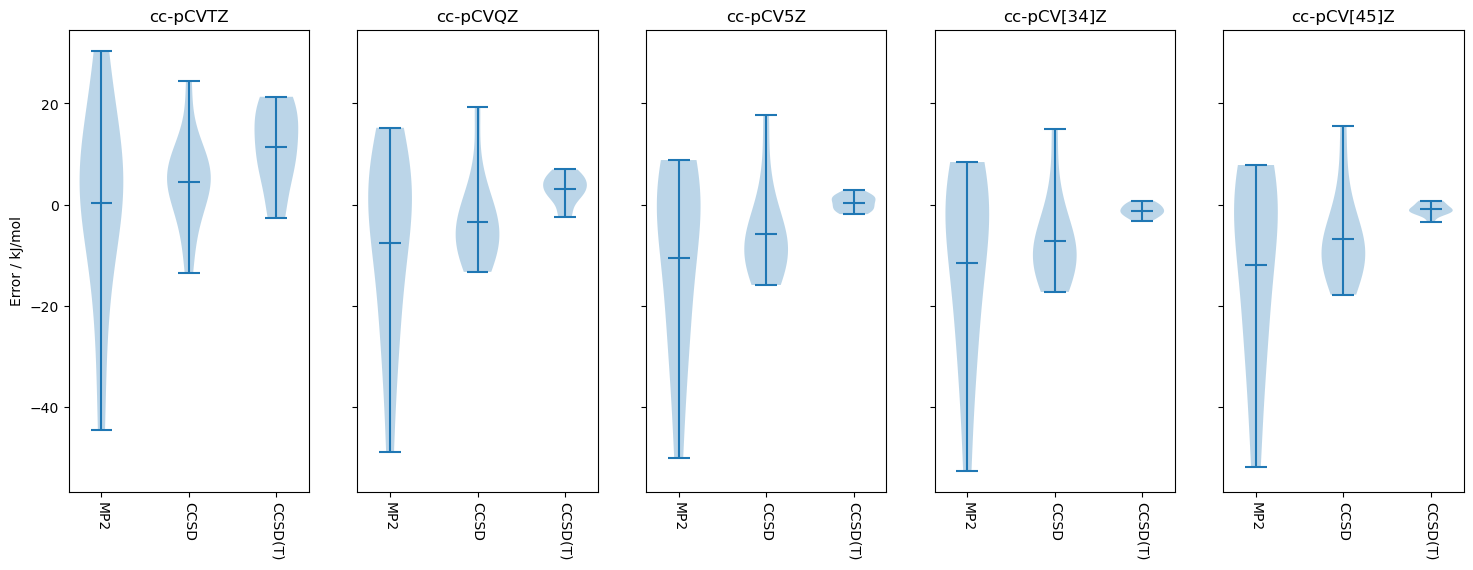

In [10]:
import matplotlib.pyplot as plt

methods_pruned = [method for method in methods if method != 'HF']
bases_pruned = ['cc-pCVTZ', 'cc-pCVQZ', 'cc-pCV5Z', 'cc-pCV[34]Z', 'cc-pCV[45]Z']
fig, panes = plt.subplots(nrows=1, ncols=len(bases_pruned), sharey=True, figsize=(18, 6))

for pane in range(len(bases_pruned)):
    data = []
    for method in methods_pruned:
        data.append(
            pymolpro.database.compare(results[method][bases_pruned[pane]],
                                      db.reference_results())['reaction energy errors'].to_numpy()[:, 0] * tokj
        )
    panes[pane].violinplot(data, showmeans=True, showextrema=True, vert=True, bw_method='silverman')
    panes[pane].set_xticks(range(1, len(methods_pruned) + 1), labels=methods_pruned, rotation=-90)
    panes[pane].set_title(bases_pruned[pane])
panes[0].set_ylabel('Error / kJ/mol')
plt.savefig(project_name + ".violin.pdf")

In [11]:
with open(project_name + '.tex', 'w') as tf:
    tf.write('\\def\\toprule{\\hline\\hline}\n\\def\\midrule{\\hline}\n\\def\\bottomrule{\\hline\\hline}')
    tf.write(df_exp_reaction_meanerror.style.to_latex())
    tf.write(df_exp_reaction_std.style.to_latex())
    tf.write(df_exp_reaction_meanabserror.style.to_latex())
    tf.write(df_exp_reaction_maxerror.style.to_latex())

NameError: name 'df_exp_reaction_meanerror' is not defined